In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tabulate import tabulate

In [ ]:
from sklearn.linear_model import LinearRegression

## Assignment 1: Compound Interest Calculator

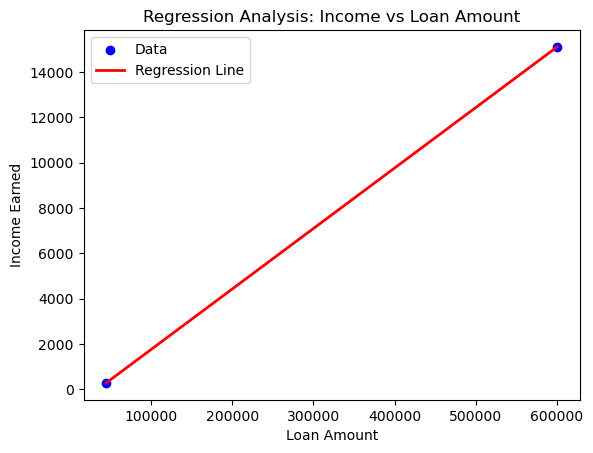

In [ ]:
def calculate_repayment_schedule(loan_amount, interest_rate, total_months, fixed_intervals=False, fixed_payment=None):
    monthly_interest_rate = interest_rate / 12 / 100
    
    if not fixed_intervals:
        monthly_payment = loan_amount * monthly_interest_rate / (1 - (1 + monthly_interest_rate) ** -total_months)
        
        schedule = []
        remaining_amount = loan_amount
        for month in range(1, total_months + 1):
            interest_payment = remaining_amount * monthly_interest_rate
            principal_payment = monthly_payment - interest_payment
            remaining_amount -= principal_payment
            schedule.append([month, remaining_amount, principal_payment, interest_payment])
    else:
        schedule = []
        remaining_amount = loan_amount
        month = 1
        while remaining_amount > 0 and month <= total_months:
            if fixed_payment is None:
                fixed_payment = float(input("Enter monthly payment amount for user: "))
            interest_payment = remaining_amount * monthly_interest_rate
            principal_payment = min(fixed_payment - interest_payment, remaining_amount)
            remaining_amount -= principal_payment
            schedule.append([month, remaining_amount, principal_payment, interest_payment])
            month += 1
            
        # Adjust fixed payment amount if needed to ensure loan is fully repaid on time
        while remaining_amount > 0:
            fixed_payment += 1  # Increase fixed payment amount by 1
            remaining_amount = loan_amount
            schedule = []
            month = 1
            while remaining_amount > 0 and month <= total_months:
                interest_payment = remaining_amount * monthly_interest_rate
                principal_payment = min(fixed_payment - interest_payment, remaining_amount)
                remaining_amount -= principal_payment
                schedule.append([month, remaining_amount, principal_payment, interest_payment])
                month += 1
    
    return schedule, fixed_payment

def plot_schedule(schedule):
    months = [entry[0] for entry in schedule]
    remaining_amounts = [entry[1] for entry in schedule]

    plt.plot(months, remaining_amounts, marker='o')
    plt.xlabel('Months')
    plt.ylabel('Loan Balance')
    plt.title('Loan Repayment Schedule')
    plt.grid(True)
    plt.show()

def display_table(schedule):
    headers = ["Month", "Remaining Amount", "Principal Payment", "Interest Payment"]
    print(tabulate(schedule, headers=headers, tablefmt="grid"))

def perform_regression_analysis(X, y, label):
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    plt.scatter(X, y, color='blue', label='Data')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
    plt.xlabel(label)
    plt.ylabel('Income Earned')
    plt.title('Regression Analysis: Income vs {}'.format(label))
    plt.legend()
    plt.show()
    return model

if __name__ == "__main__":
    users = {}
    total_loan_amount = 0
    total_interest_earned = 0
    monthly_interest_earned = {}
    interest_rates = []
    loan_amounts = []
    incomes = []
    
    while True:
        user_name = input("Enter user's name (type 'done' to finish): ")
        if user_name.lower() == 'done':
            break
        
        loan_amount = float(input("Enter loan amount for {}: ".format(user_name)))
        interest_rate = float(input("Enter interest rate (annual %) for {}: ".format(user_name)))
        total_months = int(input("Enter the number of months for {} to pay back the loan: ".format(user_name)))
        fixed_intervals = input("Would {} like to pay back in fixed intervals? (yes/no): ".format(user_name)).lower() == 'yes'
        
        if fixed_intervals:
            fixed_payment = float(input("How much will {} be able to pay at fixed intervals? ".format(user_name)))
            if fixed_payment is not None and fixed_payment < loan_amount / total_months:
                print("The fixed payment amount is too small to ensure the loan is fully repaid on time. Adjusting...")
                fixed_payment = None
        else:
            fixed_payment = None
        
        schedule, fixed_payment = calculate_repayment_schedule(loan_amount, interest_rate, total_months, fixed_intervals, fixed_payment)
        users[user_name] = schedule
        
        # Update total loan amount and total interest earned
        total_loan_amount += loan_amount
        total_interest_earned += sum(entry[3] for entry in schedule)
        
        # Update monthly interest earned
        for entry in schedule:
            month = entry[0]
            interest_earned = entry[3]
            if month not in monthly_interest_earned:
                monthly_interest_earned[month] = 0
            monthly_interest_earned[month] += interest_earned
            
        interest_rates.append(interest_rate)
        loan_amounts.append(loan_amount)
        incomes.append(sum(entry[3] for entry in schedule))
    
    highest_earning_month = max(monthly_interest_earned, key=monthly_interest_earned.get)
    
    for user, schedule in users.items():
        print("\nRepayment schedule for {}:".format(user))
        display_table(schedule)
        plot_schedule(schedule)
    
    total_months = max(len(schedule) for schedule in users.values())
    average_income_per_month = total_interest_earned / total_months
    total_income = sum(sum(entry[3] for entry in schedule) for schedule in users.values())
    
    print("\nTotal money lent by the loan company: ${:.2f}".format(total_loan_amount))
    print("Total income for the loan company over {} months: ${:.2f}".format(total_months, total_income))
    print("Average income per month for the loan company over {} months: ${:.2f}".format(total_months, average_income_per_month))
    print("Highest earning month for the company: Month {}".format(highest_earning_month))

 # Perform regression analysis for interest rates
    interest_rates = np.array(interest_rates).reshape(-1, 1)
    model_interest_rate = perform_regression_analysis(interest_rates, incomes, 'Interest Rate')
    
    # Perform regression analysis for loan amounts
    loan_amounts = np.array(loan_amounts).reshape(-1, 1)
    model_loan_amount = perform_regression_analysis(loan_amounts, incomes, 'Loan Amount')


## Assignment 2: Queue Simulation

In [ ]:
import simpy
import numpy as np

class QueueSystem:
    def __init__(self, env, num_servers, service_rate, arrival_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=num_servers)
        self.service_rate = service_rate
        self.arrival_rate = arrival_rate
        self.waiting_times = []

    def customer_arrival(self):
        while True:
            inter_arrival_time = np.random.exponential(1 / self.arrival_rate)
            yield self.env.timeout(inter_arrival_time)
            self.env.process(self.customer_service())

    def customer_service(self):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            service_time = np.random.exponential(1 / self.service_rate)
            yield self.env.timeout(service_time)
            service_end_time = self.env.now
            waiting_time = service_end_time - arrival_time
            self.waiting_times.append(waiting_time)

def run_simulation(num_servers, service_rate, arrival_rate, sim_duration):
    env = simpy.Environment()
    queue_system = QueueSystem(env, num_servers, service_rate, arrival_rate)
    env.process(queue_system.customer_arrival())
    env.run(until=sim_duration)

    avg_waiting_time = np.mean(queue_system.waiting_times)
    server_utilization = queue_system.server.count / (num_servers * sim_duration)

    print("Simulation Results:")
    print(f"Average Waiting Time: {avg_waiting_time:.2f} time units")
    print(f"Server Utilization: {server_utilization:.2f}")

if __name__ == "__main__":
    num_servers = 1
    service_rate = 1.5  # Customers served per time unit
    arrival_rate = 1.0  # Customers arriving per time unit
    sim_duration = 1000  # Duration of simulation (time units)

    run_simulation(num_servers, service_rate, arrival_rate, sim_duration)
import simpy
import numpy as np

class QueueSystem:
    def __init__(self, env, num_servers, service_rate, arrival_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=num_servers)
        self.service_rate = service_rate
        self.arrival_rate = arrival_rate
        self.waiting_times = []

    def customer_arrival(self):
        while True:
            inter_arrival_time = np.random.exponential(1 / self.arrival_rate)
            yield self.env.timeout(inter_arrival_time)
            self.env.process(self.customer_service())

    def customer_service(self):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            service_time = np.random.exponential(1 / self.service_rate)
            yield self.env.timeout(service_time)
            service_end_time = self.env.now
            waiting_time = service_end_time - arrival_time
            self.waiting_times.append(waiting_time)

def run_simulation(num_servers, service_rate, arrival_rate, sim_duration):
    env = simpy.Environment()
    queue_system = QueueSystem(env, num_servers, service_rate, arrival_rate)
    env.process(queue_system.customer_arrival())
    env.run(until=sim_duration)

    avg_waiting_time = np.mean(queue_system.waiting_times)
    server_utilization = queue_system.server.count / (num_servers * sim_duration)

    print("Simulation Results:")
    print(f"Average Waiting Time: {avg_waiting_time:.2f} time units")
    print(f"Server Utilization: {server_utilization:.2f}")

if __name__ == "__main__":
    num_servers = 1
    service_rate = 1.5  # Customers served per time unit
    arrival_rate = 1.0  # Customers arriving per time unit
    sim_duration = 1000  # Duration of simulation (time units)

    run_simulation(num_servers, service_rate, arrival_rate, sim_duration)
class QueueSystem:
    def __init__(self, env, num_servers, service_rate, arrival_rate):
        self.env = env
        self.server = simpy.Resource(env, capacity=num_servers)
        self.service_rate = service_rate
        self.arrival_rate = arrival_rate
        self.waiting_times = []

    def customer_arrival(self):
        while True:
            inter_arrival_time = np.random.exponential(1 / self.arrival_rate)
            yield self.env.timeout(inter_arrival_time)
            self.env.process(self.customer_service())

    def customer_service(self):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            service_time = np.random.exponential(1 / self.service_rate)
            yield self.env.timeout(service_time)
            service_end_time = self.env.now
            waiting_time = service_end_time - arrival_time
            self.waiting_times.append(waiting_time)

def run_simulation(num_servers, service_rate, arrival_rate, sim_duration):
    env = simpy.Environment()
    queue_system = QueueSystem(env, num_servers, service_rate, arrival_rate)
    env.process(queue_system.customer_arrival())
    env.run(until=sim_duration)

    avg_waiting_time = np.mean(queue_system.waiting_times)
    server_utilization = queue_system.server.count / (num_servers * sim_duration)

    print("Simulation Results:")
    print(f"Average Waiting Time: {avg_waiting_time:.2f} time units")
    print(f"Server Utilization: {server_utilization:.2f}")

if __name__ == "__main__":
    num_servers = 1
    service_rate = 1.5  # Customers served per time unit
    arrival_rate = 1.0  # Customers arriving per time unit
    sim_duration = 1000  # Duration of simulation (time units)

    run_simulation(num_servers, service_rate, arrival_rate, sim_duration)
